In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_path = '/content/drive/MyDrive/data/images-20241222T095027Z-001.zip'  # Replace with your ZIP file path
extract_path = '/content/drive/MyDrive/data'  # Replace with desired extraction path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [3]:
!pip install silence_tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for silence_tensorflow: filename=silence_tensorflow-1.2.3-py3-none-any.whl size=6749 sha256=ca4fd7f83a110c086d4b48cd6efa5e426e0e7edfcfe841108c65e4d64ec37294
  Stored in directory: /root/.cache/pip/wheels/2e/91/a1/2d32c0ea21439c6367fe1acaa2d3a0377a95ae51cf47c13521
Successfully built silence_tensorflow


In [4]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# **IMPORT LIBRARY**

In [5]:
import os
import cv2
import random
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copy2
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [6]:
print(tf.__version__)

2.17.1


In [7]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [8]:
def resize_image(input_path, output_path, size=(224, 224)):
    """Resize image to the specified size and save it to the output path."""
    with Image.open(input_path) as img:
        # Konversi gambar ke mode RGB jika gambar berada dalam mode RGBA atau mode lainnya
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = img.resize(size, Image.LANCZOS)
        img.save(output_path)

def process_directory(input_dir, output_dir, size=(224, 224)):
    """Process all images in the input directory and save them to the output directory."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                input_file_path = os.path.join(root, file)
                output_file_path = os.path.join(output_dir, os.path.relpath(input_file_path, input_dir))

                # Create the output directory if it does not exist
                output_file_dir = os.path.dirname(output_file_path)
                if not os.path.exists(output_file_dir):
                    os.makedirs(output_file_dir)

                # Resize and save the image
                resize_image(input_file_path, output_file_path, size)

In [9]:
input_base_dir = '/content/drive/MyDrive/data/images'
output_base_dir = '/content/drive/MyDrive/data/data224x224'

process_directory(input_base_dir, output_base_dir, size=(224, 224))

print("Image resizing completed!")

Image resizing completed!


In [10]:
dir_data_224 = '/content/drive/MyDrive/data/data224x224'
dir_tvt = '/content/drive/MyDrive/data/data-tvt'

In [11]:
deases_class = [dir for dir in os.listdir(dir_data_224) if os.path.isdir(os.path.join(dir_data_224, dir))]
print(deases_class)

['heat-sink', 'limiter-clipper', 'attenuator', 'memory-chip', 'filament', 'solenoid', 'cartridge-fuse', 'step-down-transformer', 'jumper-cable', 'armature', 'potentiometer', 'semiconductor-diode', 'microchip', 'LED', 'microprocessor', 'pulse-generator', 'clip-lead', 'Electrolytic-capacitor']


In [12]:
# Loop over each vegetable directory
for desases in deases_class:
    print(desases)
    deases_path = os.path.join(dir_data_224, desases) #\data224x224\Coccidiosis
    all_image_paths = []

    if os.path.exists(deases_path):
        paths = [os.path.join(deases_path, f) for f in os.listdir(deases_path) if os.path.isfile(os.path.join(deases_path, f))]
        all_image_paths.extend(paths)

    random.shuffle(all_image_paths)

    # Split images into train, validation, and test sets
    num_images = len(all_image_paths)
    train_size = int(0.8 * num_images)
    valid_size = int(0.1 * num_images)
    test_size = num_images - train_size - valid_size

    train_paths = all_image_paths[:train_size]
    valid_paths = all_image_paths[train_size:train_size + valid_size]
    test_paths = all_image_paths[train_size + valid_size:]

    # Copy images
    for path in train_paths:
        dst_dir = os.path.join(dir_tvt, 'train', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))

    for path in valid_paths:
        dst_dir = os.path.join(dir_tvt, 'validation', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))

    for path in test_paths:
        dst_dir = os.path.join(dir_tvt, 'test', desases)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        copy2(path, os.path.join(dst_dir, os.path.basename(path)))


heat-sink
limiter-clipper
attenuator
memory-chip
filament
solenoid
cartridge-fuse
step-down-transformer
jumper-cable
armature
potentiometer
semiconductor-diode
microchip
LED
microprocessor
pulse-generator
clip-lead
Electrolytic-capacitor


# **IMPORT DATA**

In [13]:
base_dir = '/content/drive/MyDrive/data/data-tvt'
full_path = '/content/drive/MyDrive/data/data224x224'

train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'validation')
test_path = os.path.join(base_dir, 'test')

# **Count data and classes**

In [14]:
train_dir = os.path.join(dir_tvt, 'train')
validation_dir = os.path.join(dir_tvt, 'validation')
test_dir = os.path.join(dir_tvt, 'test')

In [15]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [16]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 18
number of classes in validation folder : 18
number of classes in test folder : 18


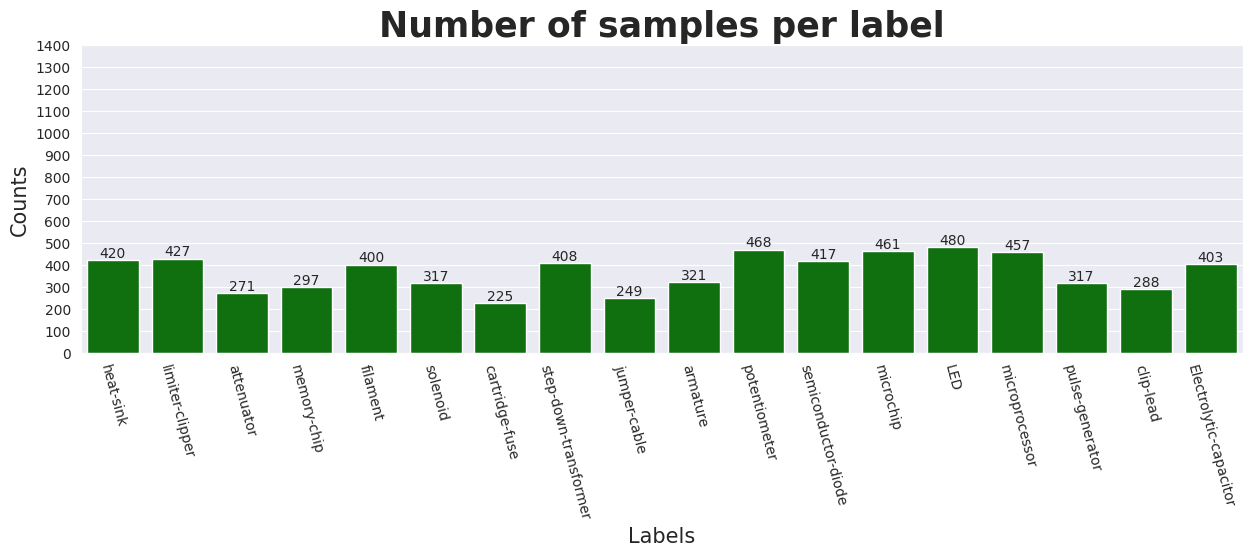

In [17]:
classes = [class_name for class_name in os.listdir(full_path)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(full_path, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='Green')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 1500, 100))
plt.show()

# **Convert data to a DataFrame**

In [18]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [19]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [20]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 5293
Number of samples in validation : 654
Number of samples test : 679


# **visualisasi image**

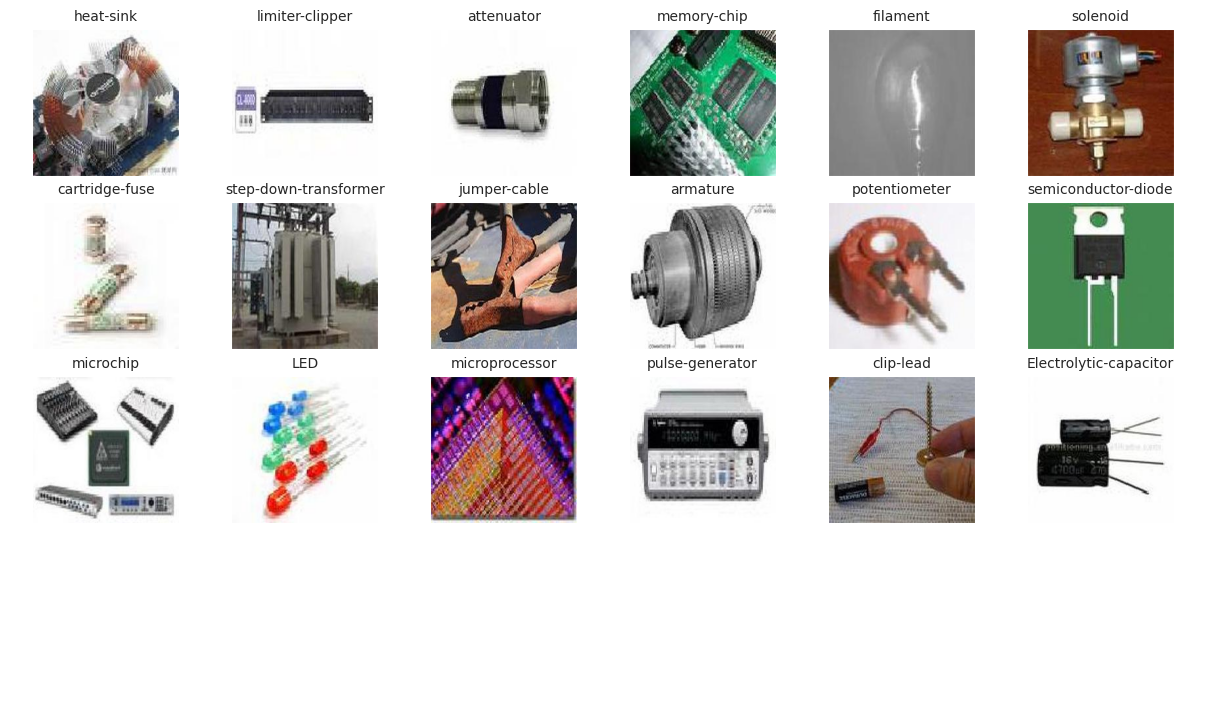

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [22]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 5293 validated image filenames belonging to 18 classes.


In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 654 validated image filenames belonging to 18 classes.


In [24]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 679 validated image filenames belonging to 18 classes.


# **Build Resnet50 model**

In [25]:
pre_trained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    classifier_activation='softmax',      # activation function
    pooling='avg'                         # type of pooling layer
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Freeze ResNet50 layers**

In [27]:
for i, layer in enumerate(pre_trained_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [28]:
# Freeze the layers up to conv4_block6_out
for layer in pre_trained_model.layers[:143]: # include the layer 142
    layer.trainable = False

# **Mendefinisikan model**

In [29]:
# Create the new model
x = pre_trained_model.output
# x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(18, activation='softmax')(x)

transfer_resnet50_model = tf.keras.models.Model(
    inputs=pre_trained_model.input,
    outputs=x
)

In [30]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,624,594 (90.12 MB)

 Trainable params: 15,012,882 (57.27 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

# **Compile Model**

In [31]:
transfer_resnet50_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [32]:
# Define the callbacks
# Model CheckPoint
checkpoint_cb = ModelCheckpoint(
    'my_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Early Stoping
earlystop_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor='val_loss',
    mode='min'
)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5,
    verbose=1,
    mode='min'
)

# Train the model
history = transfer_resnet50_model.fit(
    train_generator,
    epochs=250,
    batch_size=32,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.1397 - loss: 2.7366
Epoch 1: val_loss improved from inf to 2.92579, saving model to my_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 130s 621ms/step - accuracy: 0.1399 - loss: 2.7360 - val_accuracy: 0.1254 - val_loss: 2.9258 - learning_rate: 1.0000e-04
Epoch 2/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.1982 - loss: 2.5287
Epoch 2: val_loss did not improve from 2.92579
166/166 ━━━━━━━━━━━━━━━━━━━━ 90s 526ms/step - accuracy: 0.1982 - loss: 2.5286 - val_accuracy: 0.1453 - val_loss: 3.2929 - learning_rate: 1.0000e-04
Epoch 3/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.2178 - loss: 2.4330
Epoch 3: val_loss improved from 2.92579 to 2.50984, saving model to my_model.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 143s 532ms/step - accuracy: 0.2178 - loss: 2.4330 - val_accuracy: 0.1972 - val_loss: 2.5098 - learning_rate: 1.0000e-04
Epoch 4/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2233 - lo

# **Plot the result of training**

In [33]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
26,0.474022,1.616119,0.396024,2.021005,0.00001
27,0.483658,1.586252,0.399083,2.004154,0.00001
28,0.486492,1.570470,0.380734,2.043762,0.00001
29,0.500661,1.554086,0.388379,2.004393,0.00001
30,0.506329,1.542232,0.386850,2.055446,0.00001


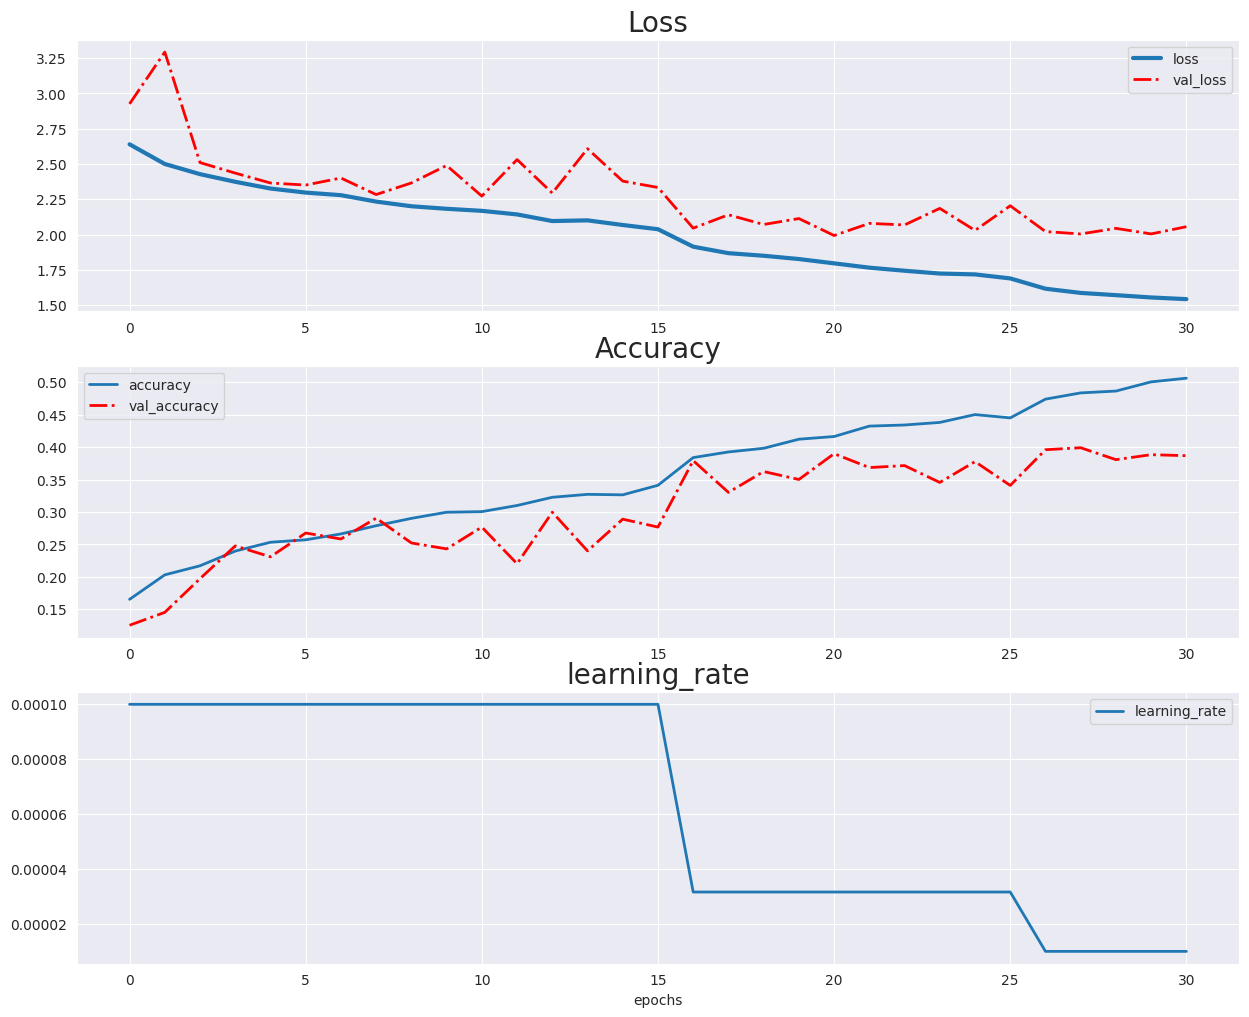

In [34]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [35]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Electrolytic-capacitor
1 : LED
2 : armature
3 : attenuator
4 : cartridge-fuse
5 : clip-lead
6 : filament
7 : heat-sink
8 : jumper-cable
9 : limiter-clipper
10 : memory-chip
11 : microchip
12 : microprocessor
13 : potentiometer
14 : pulse-generator
15 : semiconductor-diode
16 : solenoid
17 : step-down-transformer


In [36]:
predictions = transfer_resnet50_model.predict(test_generator)

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step


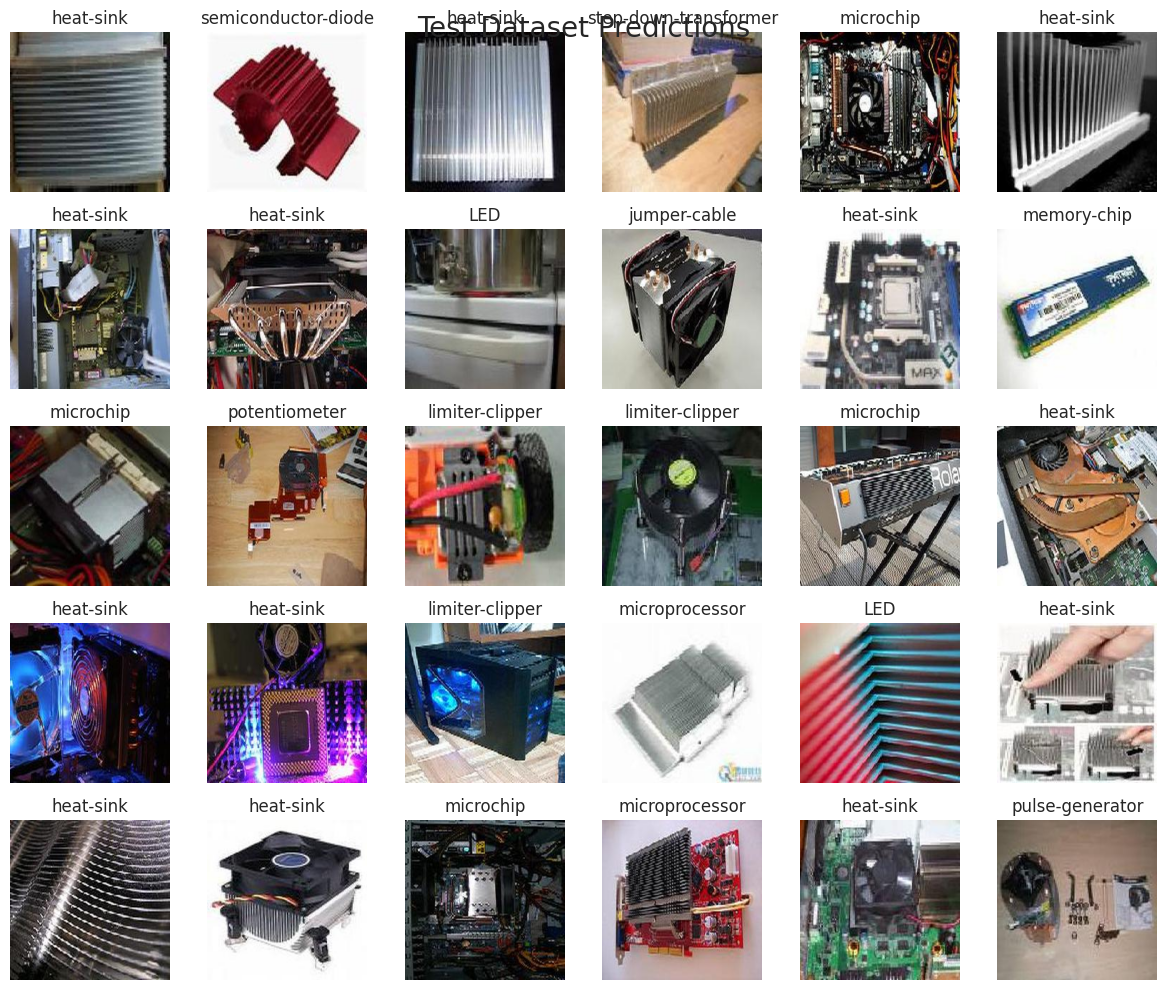

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [38]:
test_loss, test_accuracy = transfer_resnet50_model.evaluate(test_generator, batch_size=32)

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4148 - loss: 2.0099


In [39]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     2.048525333404541
Test Accuracy: 0.40058910846710205 -> 40.06%


# **PLOT CONFUSION MATRIX**

In [40]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

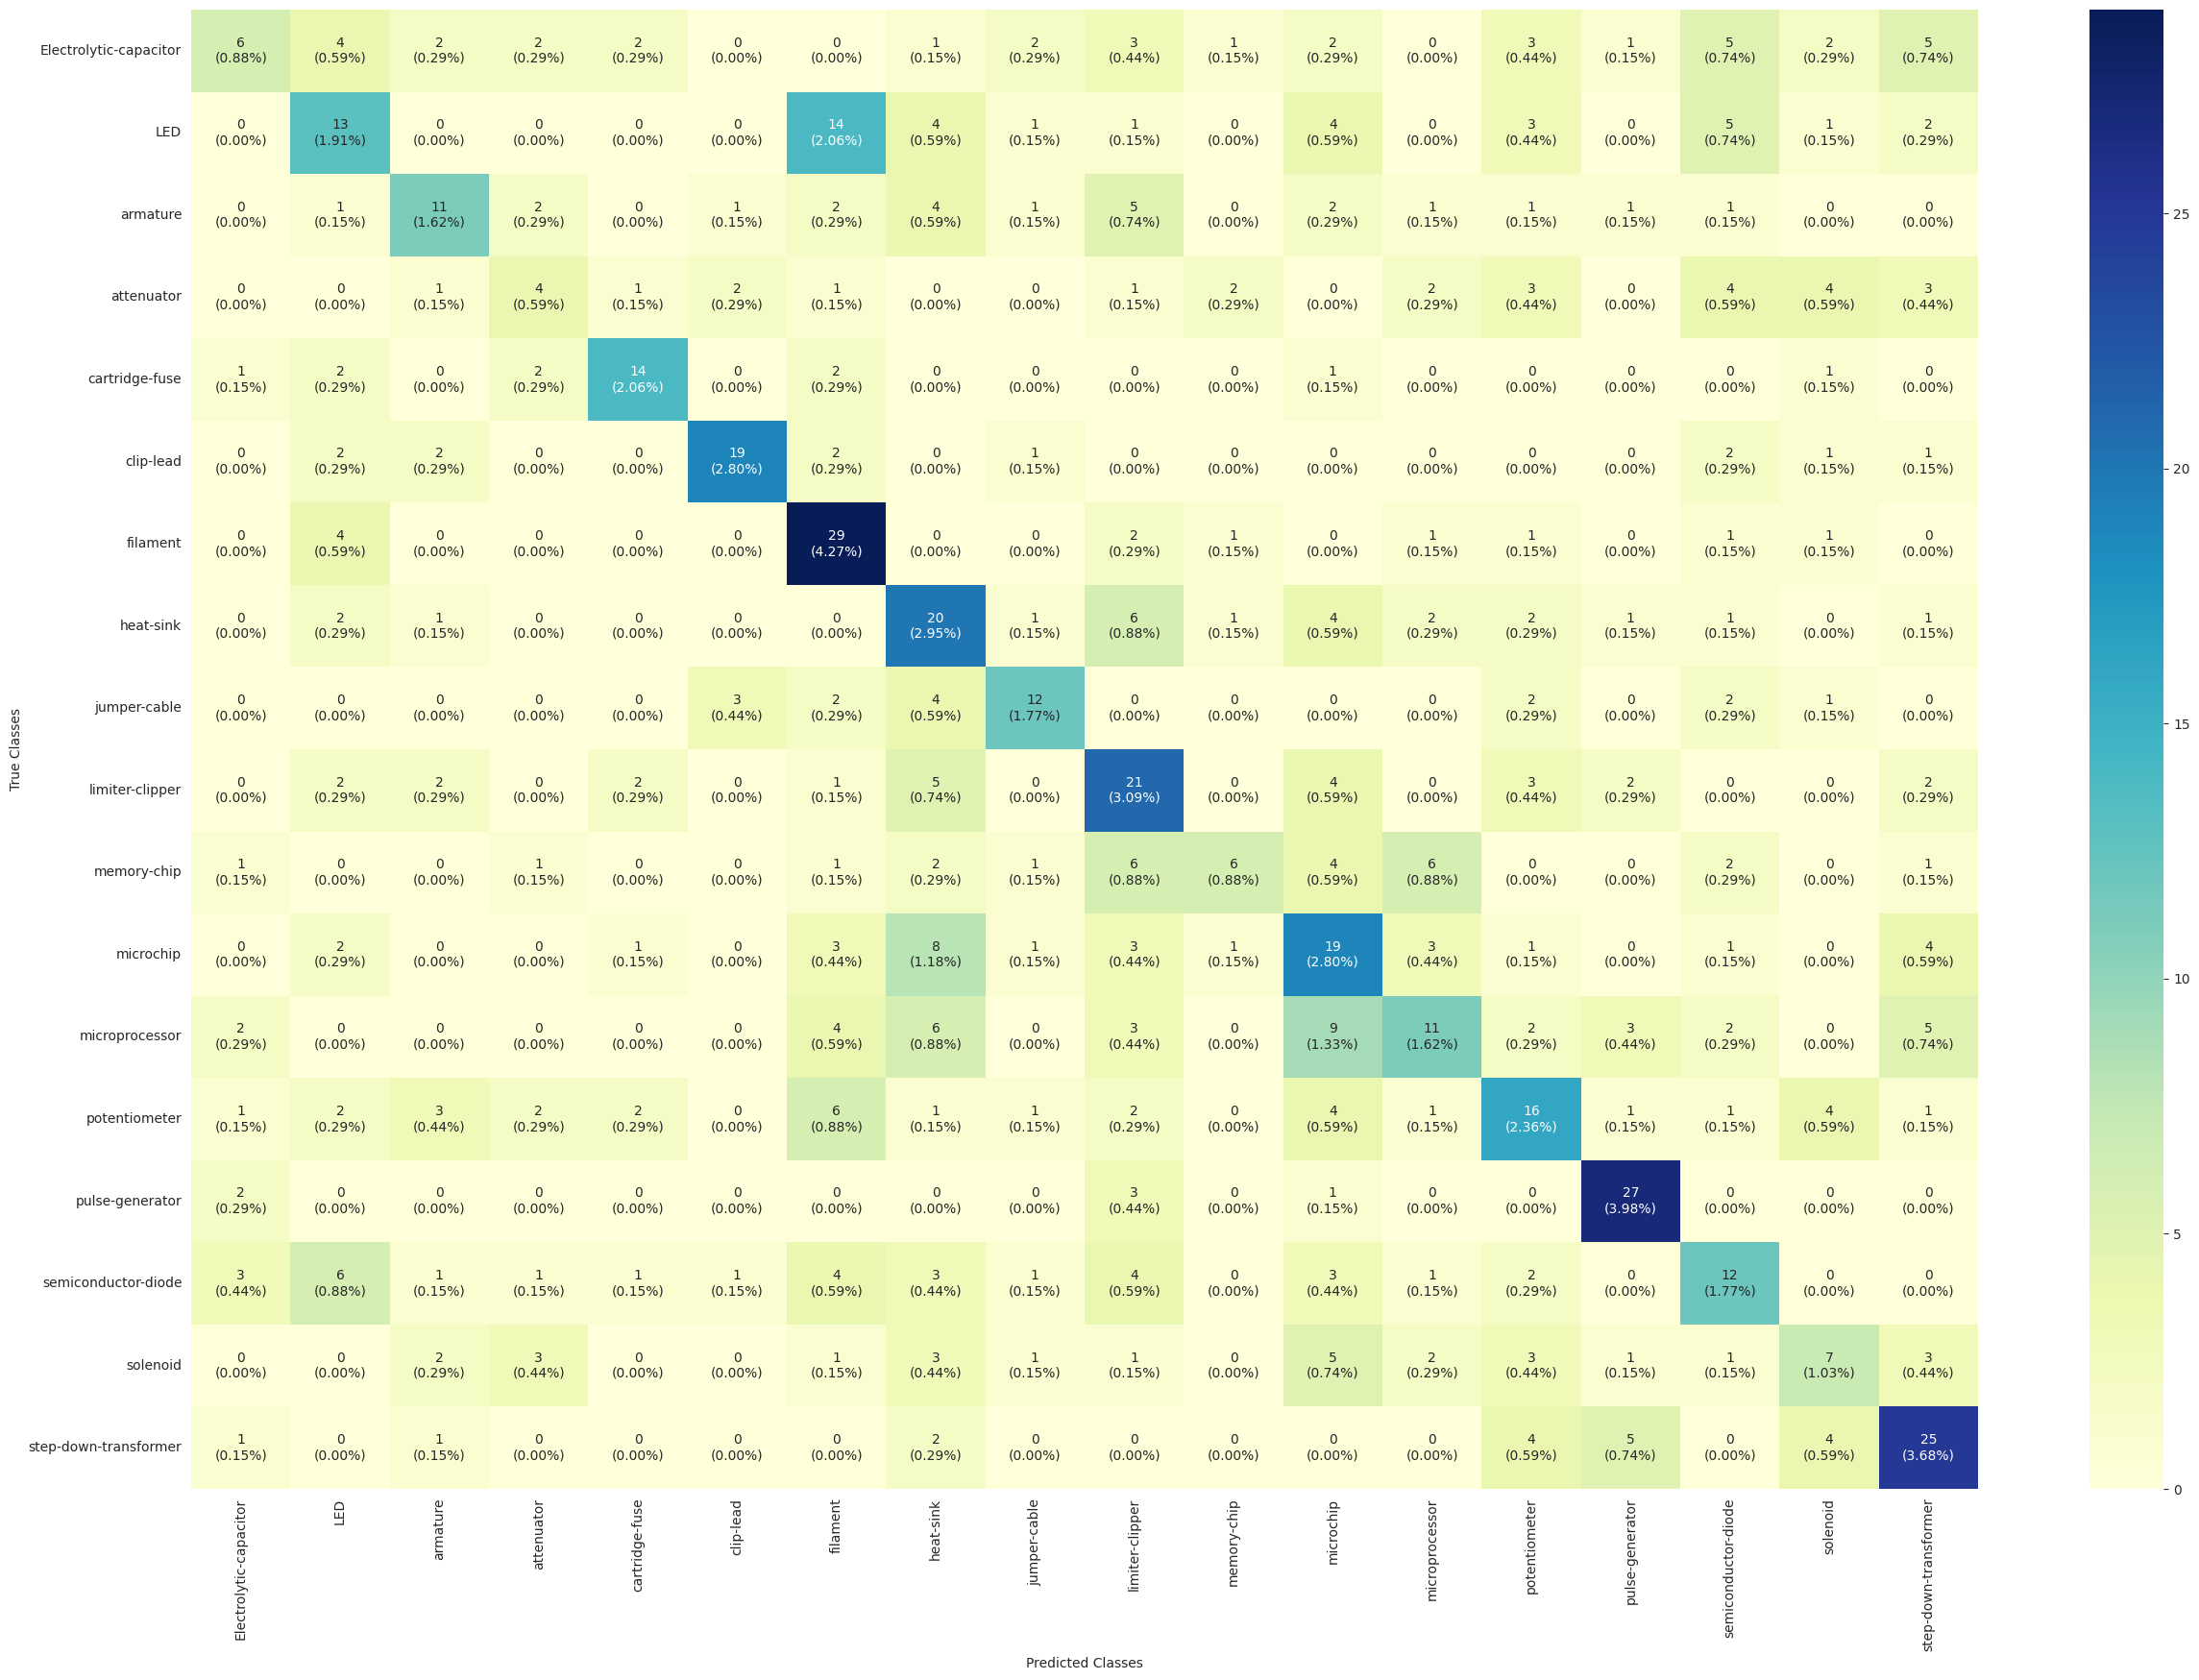

In [42]:
cf_mtx = confusion_matrix(y_true, y_hat)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(18, 18)

plt.figure(figsize = (30, 20))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [43]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

                        precision    recall  f1-score   support

Electrolytic-capacitor       0.35      0.15      0.21        41
                   LED       0.33      0.27      0.30        48
              armature       0.42      0.33      0.37        33
            attenuator       0.24      0.14      0.18        28
        cartridge-fuse       0.61      0.61      0.61        23
             clip-lead       0.73      0.63      0.68        30
              filament       0.40      0.72      0.52        40
             heat-sink       0.32      0.48      0.38        42
          jumper-cable       0.52      0.46      0.49        26
       limiter-clipper       0.34      0.48      0.40        44
           memory-chip       0.50      0.19      0.28        31
             microchip       0.31      0.40      0.35        47
        microprocessor       0.37      0.23      0.29        47
         potentiometer       0.35      0.33      0.34        48
       pulse-generator       0.64      

# **WRONG PREDICT**

In [44]:
y_true = np.array(y_true)
print(y_true.shape)

(679,)


In [45]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [46]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 679
Jumlah prediksi yang salah: 407
Persentase prediksi yang salah: 59.941089837997055%


In [47]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [50]:
transfer_resnet50_model.save("/content/drive/MyDrive/data/model_resnet50.h5")

In [51]:
transfer_resnet50_model.save('/content/drive/MyDrive/data/model_resnet50.keras')

In [52]:
transfer_resnet50_model.save_weights('/content/drive/MyDrive/data/model_resnet50.weights.h5')

In [ ]:
# prompt: cek model dengan menguploud gambar

from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Praktikum_semester7/UAP/model_resnet50.keras')

# Assuming 'uploaded' contains the uploaded image
for fn in uploaded.keys():
  # Load and preprocess the image
  img_path = fn
  img = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
  img = img.resize((224, 224), Image.LANCZOS)  # Resize the image
  img_array = np.array(img) / 255.0  # Normalize pixel values
  img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

  # Make a prediction
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions)

  # Get prediction percentage
  confidence = predictions[0][predicted_class] * 100 # Get the confidence score for the predicted class

  # Get class labels from the training generator
  labels = {value: key for key, value in train_generator.class_indices.items()}
  predicted_label = labels.get(predicted_class)

  print(f"The predicted label for {fn} is: {predicted_label} with {confidence:.2f}% confidence.")